# 초기 세팅

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [117]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [118]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [120]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # PIL Image -> Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [172]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content', # 이곳에 MNIST폴더안에 데이터가 저장된다.
                          train=True, download=True,
                          transform=CIFAR_transform) # 어떤 transform을 할 것인가

testset = torchvision.datasets.CIFAR10(root='/content',
                         train=False, download=True,
                         transform=CIFAR_transform)

Files already downloaded and verified
Files already downloaded and verified


In [173]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [123]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

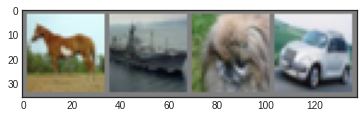

horse	 ship	 dog	 car	


In [124]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [125]:
class Net(nn.Module):  
    def __init__ (self):
      super(Net, self).__init__()

      self.conv1 = nn.Conv2d(3,6,3,1,0)
      self.conv2 = nn.Conv2d(6,6,3,1,1)

      self.fc1 = nn.Linear(6 * 15 * 15, 3000)
      self.fc2 = nn.Linear(3000, 1500)
      self.fc3 = nn.Linear(1500, 180) 
      self.fc4 = nn.Linear(180, 86)
      self.fc5 = nn.Linear(86, 10)
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)


        return x

In [126]:
myNet = Net().to(device) # gpu에 모델 저장

In [127]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [128]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [129]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 30, 30]             168
            Conv2d-2             [4, 6, 15, 15]             330
            Linear-3                  [4, 3000]       4,053,000
            Linear-4                  [4, 1500]       4,501,500
            Linear-5                   [4, 180]         270,180
            Linear-6                    [4, 86]          15,566
            Linear-7                    [4, 10]             870
Total params: 8,841,614
Trainable params: 8,841,614
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.35
Params size (MB): 33.73
Estimated Total Size (MB): 34.13
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [130]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [131]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()             # 가중치 초기화 

        outputs = myNet(inputs)             # y_pred
        loss = criterion(outputs, labels)       # 손실함수를 이용해서 loss계산
        loss.backward()                          # back-propagation
        optimizer.step()                         # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.3005434168577192
Epoch: 1, Batch: 4000, Loss: 2.1195409832894803
Epoch: 1, Batch: 6000, Loss: 1.874331055700779
Epoch: 1, Batch: 8000, Loss: 1.7179861004948616
Epoch: 1, Batch: 10000, Loss: 1.624339238755405
Epoch: 1, Batch: 12000, Loss: 1.5327221737802028
Epoch: 2, Batch: 2000, Loss: 1.4662787446901202
Epoch: 2, Batch: 4000, Loss: 1.415119611978531
Epoch: 2, Batch: 6000, Loss: 1.3668895751312375
Epoch: 2, Batch: 8000, Loss: 1.3539865895211696
Epoch: 2, Batch: 10000, Loss: 1.3374349908940495
Epoch: 2, Batch: 12000, Loss: 1.2966104582995177
Epoch: 3, Batch: 2000, Loss: 1.2000476741530002
Epoch: 3, Batch: 4000, Loss: 1.1964284520111979
Epoch: 3, Batch: 6000, Loss: 1.1688663450106977
Epoch: 3, Batch: 8000, Loss: 1.1708708158619703
Epoch: 3, Batch: 10000, Loss: 1.1706905946154147
Epoch: 3, Batch: 12000, Loss: 1.1355582947283984
Epoch: 4, Batch: 2000, Loss: 0.9875638009663671
Epoch: 4, Batch: 4000, Loss: 1.001654402541928
Epoch: 4, Batch: 6000, Loss: 0.9992014

## 모델의 저장 및 로드

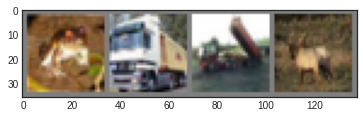

	frog 	truck 	truck 	deer


In [152]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [153]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [157]:
# 불러오기

Loaded_Net = Net()
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [177]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device) # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                         # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

75.0


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [176]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = myNet(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 66.3%
Accuracy of car: 84.0%
Accuracy of bird: 47.2%
Accuracy of cat: 44.7%
Accuracy of deer: 52.6%
Accuracy of dog: 41.5%
Accuracy of frog: 63.0%
Accuracy of horse: 66.9%
Accuracy of ship: 79.3%
Accuracy of truck: 60.0%
